In [99]:
import numpy as np
import os

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape

import tensorflow_datasets as tfds

In [100]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limit GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [101]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [102]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [103]:
# Thor DataLoad
# Specify the path to the manually downloaded dataset
data_dir = r'C:\Users\computer\OneDrive\Dokumenter\Uni\Kandidat\AML\Exam\Data\patch_camelyon'

# Load PatchCamelyon dataset using TFDS
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, image # Here i make sure that labels are not passed through since the AE does not use labels

In [104]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:20%]','test[:5%]','validation[:5%]'],
                        data_dir = data_dir,
                        download=False,
                        shuffle_files=True)

In [105]:
train_dataset       = ds1.map(convert_sample).batch(16)
validation_dataset  = ds3.map(convert_sample).batch(16)
test_dataset        = ds2.map(convert_sample).batch(16)

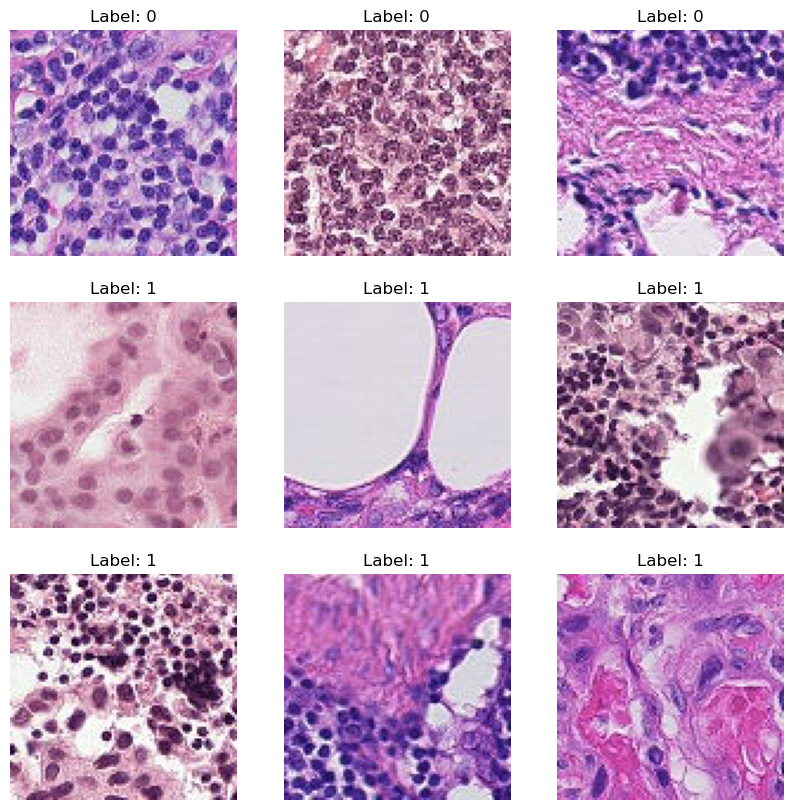

In [106]:
# Take 9 samples from the training set for visualization
samples = list(ds1.take(9))

# Display a 3x3 grid of images
plt.figure(figsize=(10, 10))
for i, sample in enumerate(samples):
    image, label = sample['image'], sample['label']
    image_array = image.numpy()

    plt.subplot(3, 3, i + 1)
    plt.imshow(image_array)
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")

plt.show()
#This is basically just to head the data to test if it represented as expected

**Problem 1:** 

During the semester you have become very excited about working on the PatchCamelyon (PCam) 
data. Like Veeling et al (2018), you are primarily interested in developing machine learning models that, based on patches of whole-slide images of lymph node sections, can assist pathologists in 
tumor detection.  

The primary objective of this exam is to perform image classification on the PCam dataset, with a 
focus on using autoencoders for image compression.  As a reminder, the PCAM dataset consists of 327,680 color images (96x96pxs) extracted from 
histopathologic scans of lymph node sections. Each image is annotated with a binary label 
indicating presence of metastatic tissue. Specifically, the dataset is divided into 262,144 training 
images, 32,768 validation images, and 32,768 test images. You must use the training/validation 
images to train/validate models that perform well at classifying the test images. Importantly, you are not required to use the full dataset. Use the amount of data that is feasible for you and your hardware configuration.

The PCam dataset is available from many online sources but 
some of them are very slow. Therefore, I recommend accessing the dataset from my SDU 
repository: Link to PCAM. Further instructions and hints on how to load the data efficiently and flexibly by using the module tfds|Tensorflow Dataset are available on the course site’s itslearning platform.

Questions:

You wish to perform image classification. However, you are a little concerned about the size of the 
PCAM images. Their size might be too demanding for your hardware configuration, potentially 
hindering proper hyperparameter tuning and downstream model evaluation. Hence, you wish as a 
pre-processing step to compress the images by using autoencoders (both AEs and VAEs).

1. Discuss how you can use autoencoders to compress images. Motivate why you think 
compressing the images by using AE/VAE will work here and will be better than just simple 
resizing for example by using the function:  

**Initial AE**

In [107]:
# Define the encoder model, simple model with alternating conv and pooling importantly the input shape is set to 96*96*3 due to the shape of the 96*96 RGB images
encoder = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),

])

# Define the decoder model, here i don't need to specify the input shape since it will use the output of the encoder
decoder = tf.keras.Sequential([
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

# Combine the encoder and decoder to form the autoencoder, standard application
autoencoder = tf.keras.Sequential([
    encoder,
    decoder
])
autoencoder.summary()
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')  # Using Mean Squared Error as the loss for reconstruction, this is normal for reconstruction

# Train the autoencoder, only 1 epoch since it is just to test 
# autoencoder.fit(train_dataset, epochs=1, validation_data=validation_dataset)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 24, 24, 128)       93248     
                                                                 
 sequential_22 (Sequential)  (None, 96, 96, 3)         93123     
                                                                 
Total params: 186,371
Trainable params: 186,371
Non-trainable params: 0
_________________________________________________________________


AE for the CNN (simple AE due to gpu crashing when encoding for the CNN)

In [108]:
autoencoded_images = autoencoder.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10


3277/3277 [==============================] - 65s 20ms/step - loss: 0.0095 - val_loss: 0.0063
Epoch 2/10
3277/3277 [==============================] - 61s 19ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 3/10
3277/3277 [==============================] - 61s 19ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 4/10
3277/3277 [==============================] - 61s 19ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 5/10
3277/3277 [==============================] - 60s 18ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 6/10
3277/3277 [==============================] - 61s 19ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 7/10
3277/3277 [==============================] - 61s 19ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 8/10
3277/3277 [==============================] - 63s 19ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 9/10
3277/3277 [==============================] - 61s 19ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 10/10
3277/3277 [==============================] - 61s 19ms/step - lo

In [109]:
def display_original_reconstructed(original_images, reconstructed_images):
    n = 5
    plt.figure(figsize=(10, 5))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.title("Original")
        plt.imshow(tf.squeeze(original_images[i]['image']))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(3, n, i + 2 * n + 1)
        plt.title("Reconstructed")
        plt.imshow(tf.squeeze(reconstructed_images[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)

    plt.show()

In [110]:
# display_original_reconstructed(list(ds2), autoencoded_images)

**AE for anomaly detection**

In [111]:

aencoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(2,), activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')], name='encoder')
adecoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(1,), activation='relu'),
    tf.keras.layers.Dense(2)], name='decoder')
aautoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')
aautoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

autoencoder.fit(train_dataset,validation_data=validation_dataset, epochs=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss')])


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 24, 24, 128)       93248     
                                                                 
 sequential_22 (Sequential)  (None, 96, 96, 3)         93123     
                                                                 
Total params: 186,371
Trainable params: 186,371
Non-trainable params: 0
_________________________________________________________________
3277/3277 [==============================] - 61s 19ms/step - loss: 0.0034 - val_loss: 0.0034


**Sample Variational Autoencoder**

It is in Part_1_VAE_test

**CNN**

In [112]:
# Here i make a new converter as to get the labels that will be needed for the CNN
def convert_sample2(sample):
    image, label = sample['image'], sample['label']  # Use the keys in the dataset to specify what we want
    image = tf.image.convert_image_dtype(image, tf.float32) # makes the data type 32 bit float
    label = tf.one_hot(label, 2, dtype=tf.float32) # Combines labels and images
    return image, label

In [113]:
# use the new converter to the train, test and validation set
train_dataset2       = ds1.map(convert_sample2).batch(32)
validation_dataset2  = ds3.map(convert_sample2).batch(32)
test_dataset2        = ds2.map(convert_sample2).batch(32)

In [114]:
# Assuming you have a sample from your dataset, for example, the first batch of the training dataset
#sample_batch = next(iter(train_dataset))

# Get the original images from the batch
#original_images = sample_batch[0]

#autoencoder.predict(train_dataset)


Initial CNN

2nd CNN (clean)

In [115]:
def second_cnn_model(): # Function to build the second cnn, it is a fucntion because it is easier to deal with.
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                            input_shape=(96, 96, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.Flatten(), # flatten before fully connected part
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax'),
        ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [116]:
model2 = second_cnn_model()
model2.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 flatten_25 (Flatten)        (None, 25600)           

In [117]:
def model_fit(model,epochs, train, validation): # Here i make a costum fit which introduces early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
    epochs  = epochs
    hist = model.fit(train,
                    validation_data=validation,
                    epochs=epochs,  # Increase the number of epochs or set it based on your requirements
                    callbacks=[callback] # This specifies the use of EarlyStopping (recognizing when further epoch yield no better result)
                    )
    return hist

In [118]:
base_hist = model_fit(model = model2, epochs = 100,train = train_dataset2, validation = validation_dataset2)

Epoch 1/100
1639/1639 [==============================] - 18s 11ms/step - loss: 0.4864 - accuracy: 0.7713 - val_loss: 0.4347 - val_accuracy: 0.7851
Epoch 2/100
1639/1639 [==============================] - 17s 11ms/step - loss: 0.4192 - accuracy: 0.8138 - val_loss: 0.4801 - val_accuracy: 0.7863
Epoch 3/100
1639/1639 [==============================] - 17s 10ms/step - loss: 0.3738 - accuracy: 0.8377 - val_loss: 0.4270 - val_accuracy: 0.7979
Epoch 4/100
1639/1639 [==============================] - 18s 11ms/step - loss: 0.3216 - accuracy: 0.8646 - val_loss: 0.4449 - val_accuracy: 0.8053
Epoch 5/100
1639/1639 [==============================] - 16s 10ms/step - loss: 0.2629 - accuracy: 0.8941 - val_loss: 0.5860 - val_accuracy: 0.7778
Epoch 6/100
1639/1639 [==============================] - 17s 10ms/step - loss: 0.2091 - accuracy: 0.9179 - val_loss: 0.6252 - val_accuracy: 0.8107
Epoch 7/100
1639/1639 [==============================] - 17s 11ms/step - loss: 0.1606 - accuracy: 0.9393 - val_loss: 0

The 1 epoch run has high validation loss and high 70% accuracy, without validation both are quite low.

Is this a case of overfitting?

3rd CNN (now i add normalization and spatial dropout)

In [119]:
def third_cnn_model_sgd(): # Function to build the second cnn, it is a fucntion because it is easier to deal with.
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                            input_shape=(96, 96, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax'),
        ])
    sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True) # SGD is a classic optimization algorithm that updates the model parameters in the direction opposite to the gradient of the loss function
    model.compile(optimizer=sgd_opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [120]:
model3_sgd = third_cnn_model_sgd()
model3_sgd.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_68 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 spatial_dropout2d_47 (Spati  (None, 94, 94, 32)       0         
 alDropout2D)                                                    
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 29, 29, 64)        18496     
                                                     

In [121]:
def third_cnn_model_adam(): # Function to build the second cnn, it is a fucntion because it is easier to deal with.
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                            input_shape=(96, 96, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax'),
        ])
    model.compile(optimizer='adam', # Adam is an adaptive learning rate optimization algorithm that is well-suited for a wide range of tasks. It often performs well in practice and requires little tuning.
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [122]:
model3_adam = third_cnn_model_adam()
model3_adam.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_72 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_73 (Bat  (None, 29, 29, 64)       256       
 chNormalization)                                                
                                                     

In [123]:
def third_cnn_model_adagrad(): # Function to build the second cnn, it is a fucntion because it is easier to deal with.
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                            input_shape=(96, 96, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax'),
        ])
    model.compile(optimizer='adagrad', # Adagrad adapts the learning rates of each parameter based on the historical gradient information. It is well-suited for sparse data.
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [124]:
model3_adagrad = third_cnn_model_adagrad()
model3_adagrad.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_76 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_77 (Bat  (None, 29, 29, 64)       256       
 chNormalization)                                                
                                                     

In [125]:
reg_hist = model_fit(model = model3_adam, epochs = 100,train = train_dataset2, validation = validation_dataset2)

Epoch 1/100
1639/1639 [==============================] - 21s 12ms/step - loss: 0.4193 - accuracy: 0.8113 - val_loss: 0.6562 - val_accuracy: 0.7002
Epoch 2/100
1639/1639 [==============================] - 20s 12ms/step - loss: 0.3468 - accuracy: 0.8514 - val_loss: 0.5059 - val_accuracy: 0.7295
Epoch 3/100
1639/1639 [==============================] - 20s 12ms/step - loss: 0.3037 - accuracy: 0.8733 - val_loss: 1.2745 - val_accuracy: 0.6087
Epoch 4/100
1639/1639 [==============================] - 20s 12ms/step - loss: 0.2718 - accuracy: 0.8881 - val_loss: 1.1201 - val_accuracy: 0.5690
Epoch 5/100
1639/1639 [==============================] - 20s 12ms/step - loss: 0.2379 - accuracy: 0.9036 - val_loss: 0.4413 - val_accuracy: 0.8046
Epoch 6/100
1639/1639 [==============================] - 20s 12ms/step - loss: 0.2033 - accuracy: 0.9188 - val_loss: 1.1829 - val_accuracy: 0.6074
Epoch 7/100
1639/1639 [==============================] - 20s 12ms/step - loss: 0.1726 - accuracy: 0.9324 - val_loss: 0

In [126]:
reg_hist_sgd = model_fit(model = model3_sgd, epochs = 100,train = train_dataset2, validation = validation_dataset2)

Epoch 1/100


1639/1639 [==============================] - 25s 15ms/step - loss: 0.4952 - accuracy: 0.7648 - val_loss: 0.4209 - val_accuracy: 0.7967
Epoch 2/100
1639/1639 [==============================] - 24s 15ms/step - loss: 0.4277 - accuracy: 0.8081 - val_loss: 0.4161 - val_accuracy: 0.8126
Epoch 3/100
1639/1639 [==============================] - 26s 16ms/step - loss: 0.4019 - accuracy: 0.8239 - val_loss: 0.4056 - val_accuracy: 0.8284
Epoch 4/100
1639/1639 [==============================] - 24s 15ms/step - loss: 0.3827 - accuracy: 0.8341 - val_loss: 0.4701 - val_accuracy: 0.7741
Epoch 5/100
1639/1639 [==============================] - 26s 16ms/step - loss: 0.3687 - accuracy: 0.8412 - val_loss: 0.4082 - val_accuracy: 0.8132
Epoch 6/100
1639/1639 [==============================] - 25s 16ms/step - loss: 0.3582 - accuracy: 0.8436 - val_loss: 0.4568 - val_accuracy: 0.7906
Epoch 7/100
1639/1639 [==============================] - 23s 14ms/step - loss: 0.3431 - accuracy: 0.8520 - val_loss: 0.3813 - val_

In [127]:
reg_hist_adagrad = model_fit(model = model3_adagrad, epochs = 100,train = train_dataset2, validation = validation_dataset2)

Epoch 1/100


1639/1639 [==============================] - 22s 13ms/step - loss: 0.4883 - accuracy: 0.7742 - val_loss: 0.4599 - val_accuracy: 0.7863
Epoch 2/100
1639/1639 [==============================] - 20s 12ms/step - loss: 0.4197 - accuracy: 0.8126 - val_loss: 0.4466 - val_accuracy: 0.7827
Epoch 3/100
1639/1639 [==============================] - 20s 12ms/step - loss: 0.3902 - accuracy: 0.8273 - val_loss: 0.4391 - val_accuracy: 0.7888
Epoch 4/100
1639/1639 [==============================] - 19s 12ms/step - loss: 0.3693 - accuracy: 0.8394 - val_loss: 0.4490 - val_accuracy: 0.7741
Epoch 5/100
1639/1639 [==============================] - 20s 12ms/step - loss: 0.3523 - accuracy: 0.8481 - val_loss: 0.4301 - val_accuracy: 0.7918
Epoch 6/100
1639/1639 [==============================] - 20s 12ms/step - loss: 0.3371 - accuracy: 0.8571 - val_loss: 0.4314 - val_accuracy: 0.7930
Epoch 7/100
1639/1639 [==============================] - 20s 12ms/step - loss: 0.3235 - accuracy: 0.8627 - val_loss: 0.4386 - val_

Resized images CNN

In [128]:
def resize_norm_img(image):
    image = tf.image.resize(image, [32,32])
    image = tf.image.rgb_to_grayscale(image)
    return image / 255.0

In [129]:
# Here i make a new converter as to get the labels that will be needed for the CNN
def convert_sample3(sample):
    image, label = sample['image'], sample['label']  # Use the keys in the dataset to specify what we want
    image = resize_norm_img(image)
    image = tf.image.convert_image_dtype(image, tf.float32) # makes the data type 32 bit float
    label = tf.one_hot(label, 2, dtype=tf.float32) # Combines labels and images
    return image, label

In [130]:
train_rez_dataset3 = ds1.map(convert_sample3).batch(32)
validation_rez_dataset3 = ds3.map(convert_sample3).batch(32)
test_rez_dataset3 = ds2.map(convert_sample3).batch(32)

In [131]:
def third_cnn_model_sgd_rez(): # Function to build the second cnn, it is a fucntion because it is easier to deal with.
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                            input_shape=(32, 32, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(2, 2), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(2, 2), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax'),
        ])
    sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True) # SGD is a classic optimization algorithm that updates the model parameters in the direction opposite to the gradient of the loss function
    model.compile(optimizer=sgd_opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [132]:
model3_sgd_rez = third_cnn_model_sgd_rez()
model3_sgd_rez.summary()


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 batch_normalization_80 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 spatial_dropout2d_52 (Spati  (None, 30, 30, 32)       0         
 alDropout2D)                                                    
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 14, 14, 64)        8256      
                                                     

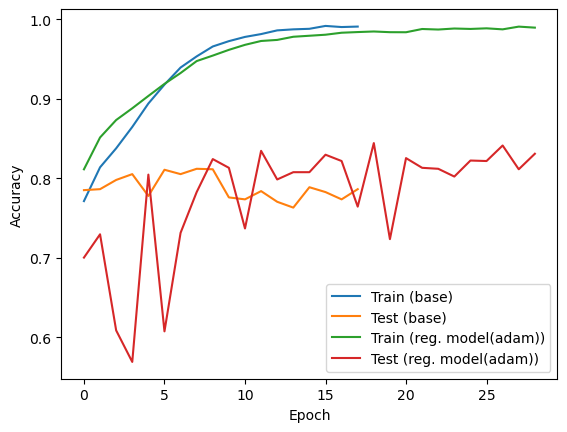

In [133]:
plt.plot(base_hist.history['accuracy'], label='Train (base)' )
plt.plot(base_hist.history['val_accuracy'], label = 'Test (base)')
plt.plot(reg_hist.history['accuracy'], label = 'Train (reg. model(adam))')
plt.plot(reg_hist.history['val_accuracy'], label = 'Test (reg. model(adam))')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


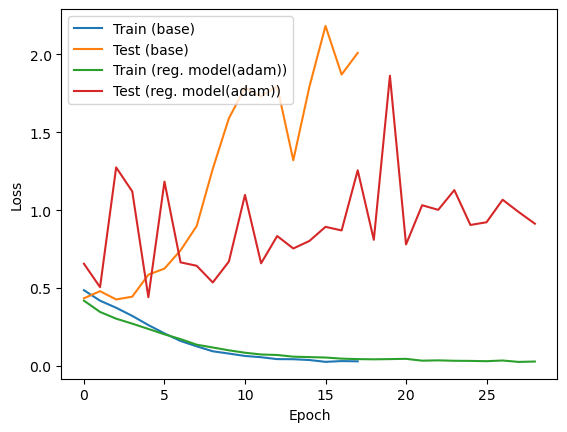

In [134]:
plt.plot(base_hist.history['loss'], label='Train (base)' )
plt.plot(base_hist.history['val_loss'], label = 'Test (base)')
plt.plot(reg_hist.history['loss'], label = 'Train (reg. model(adam))')
plt.plot(reg_hist.history['val_loss'], label = 'Test (reg. model(adam))')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


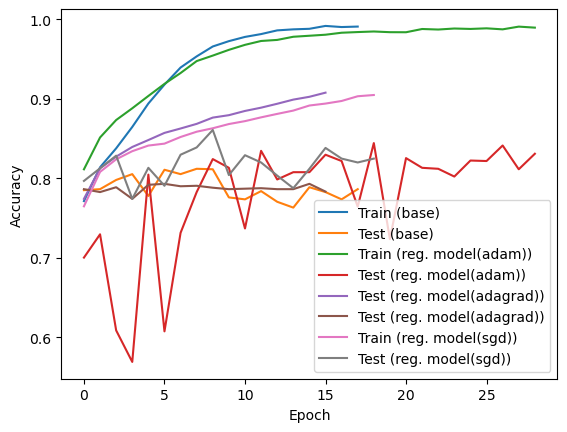

In [135]:
plt.plot(base_hist.history['accuracy'], label='Train (base)' )
plt.plot(base_hist.history['val_accuracy'], label = 'Test (base)')
plt.plot(reg_hist.history['accuracy'], label = 'Train (reg. model(adam))')
plt.plot(reg_hist.history['val_accuracy'], label = 'Test (reg. model(adam))')
plt.plot(reg_hist_adagrad.history['accuracy'], label='Test (reg. model(adagrad))')
plt.plot(reg_hist_adagrad.history['val_accuracy'], label = 'Test (reg. model(adagrad))')
plt.plot(reg_hist_sgd.history['accuracy'], label = 'Train (reg. model(sgd))')
plt.plot(reg_hist_sgd.history['val_accuracy'], label = 'Test (reg. model(sgd))')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

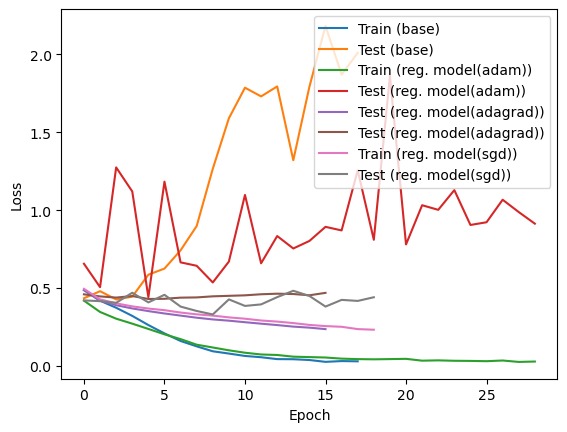

In [136]:
plt.plot(base_hist.history['loss'], label='Train (base)' )
plt.plot(base_hist.history['val_loss'], label = 'Test (base)')
plt.plot(reg_hist.history['loss'], label = 'Train (reg. model(adam))')
plt.plot(reg_hist.history['val_loss'], label = 'Test (reg. model(adam))')
plt.plot(reg_hist_adagrad.history['loss'], label='Test (reg. model(adagrad))')
plt.plot(reg_hist_adagrad.history['val_loss'], label = 'Test (reg. model(adagrad))')
plt.plot(reg_hist_sgd.history['loss'], label = 'Train (reg. model(sgd))')
plt.plot(reg_hist_sgd.history['val_loss'], label = 'Test (reg. model(sgd))')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [137]:
# Extract the validation accuracies
val_acc_adagrad = reg_hist_adagrad.history['val_accuracy']
val_acc_sgd = reg_hist_sgd.history['val_accuracy']
val_acc = reg_hist.history['val_accuracy']
val_acc_base = base_hist.history['val_accuracy']

# Find the maximum validation accuracy
max_val_acc_adagrad = max(val_acc_adagrad)
max_val_acc_sgd = max(val_acc_sgd)
max_val_acc = max(val_acc)
max_val_acc_base = max(val_acc_base)

# Find the corresponding epoch for the maximum validation accuracy
epoch_max_val_acc_adagrad = val_acc_adagrad.index(max_val_acc_adagrad) + 1  # Add 1 because epoch starts from 1
epoch_max_val_acc_sgd = val_acc_sgd.index(max_val_acc_sgd) + 1
epoch_max_val_acc = val_acc.index(max_val_acc) + 1
epoch_max_val_acc_base = val_acc_base.index(max_val_acc_base) + 1

# Print or use the results as needed
print("Max Validation Accuracy (Adagrad):", max_val_acc_adagrad)
print("Epoch of Max Validation Accuracy (Adagrad):", epoch_max_val_acc_adagrad)

print("Max Validation Accuracy (SGD):", max_val_acc_sgd)
print("Epoch of Max Validation Accuracy (SGD):", epoch_max_val_acc_sgd)

print("Max Validation Accuracy:", max_val_acc)
print("Epoch of Max Validation Accuracy:", epoch_max_val_acc)

print("Max Validation Accuracy (Base):", max_val_acc_base)
print("Epoch of Max Validation Accuracy (Base):", epoch_max_val_acc_base)


Max Validation Accuracy (Adagrad): 0.7930402755737305
Epoch of Max Validation Accuracy (Adagrad): 6
Max Validation Accuracy (SGD): 0.860805869102478
Epoch of Max Validation Accuracy (SGD): 9
Max Validation Accuracy: 0.8443223237991333
Epoch of Max Validation Accuracy: 19
Max Validation Accuracy (Base): 0.811965823173523
Epoch of Max Validation Accuracy (Base): 8


In [138]:
reg_hist_sgd_rez = model_fit(model = model3_sgd_rez, epochs = 100,train = train_rez_dataset3, validation = validation_rez_dataset3)

Epoch 1/100
1639/1639 [==============================] - 18s 11ms/step - loss: 0.5326 - accuracy: 0.7418 - val_loss: 0.4429 - val_accuracy: 0.8156
Epoch 2/100
1639/1639 [==============================] - 17s 10ms/step - loss: 0.4872 - accuracy: 0.7736 - val_loss: 0.4792 - val_accuracy: 0.7784
Epoch 3/100
1639/1639 [==============================] - 17s 11ms/step - loss: 0.4745 - accuracy: 0.7822 - val_loss: 0.4699 - val_accuracy: 0.7637
Epoch 4/100
1639/1639 [==============================] - 17s 10ms/step - loss: 0.4639 - accuracy: 0.7892 - val_loss: 0.4128 - val_accuracy: 0.8126
Epoch 5/100
1639/1639 [==============================] - 17s 11ms/step - loss: 0.4558 - accuracy: 0.7941 - val_loss: 0.4100 - val_accuracy: 0.8248
Epoch 6/100
1639/1639 [==============================] - 17s 11ms/step - loss: 0.4500 - accuracy: 0.7956 - val_loss: 0.4101 - val_accuracy: 0.8223
Epoch 7/100
1639/1639 [==============================] - 18s 11ms/step - loss: 0.4423 - accuracy: 0.8012 - val_loss: 0

4th CNN now the autoencoder is being incorporated (does not work yet)

Update: Does work i dont know why look up categorical crossentropy

In [139]:
'''
# Combine the encoder, decoder, and CNN to form the full model
combined_input = encoder.input
encoder_output = encoder.output
decoded_output = decoder(encoder_output)
final_output = model3_adam(decoded_output)

full_model_reg = tf.keras.Model(inputs=combined_input, outputs=final_output)
full_model_reg.summary()
'''


'\n# Combine the encoder, decoder, and CNN to form the full model\ncombined_input = encoder.input\nencoder_output = encoder.output\ndecoded_output = decoder(encoder_output)\nfinal_output = model3_adam(decoded_output)\n\nfull_model_reg = tf.keras.Model(inputs=combined_input, outputs=final_output)\nfull_model_reg.summary()\n'

In [140]:
'''
# Compile and train the full model - takes a long time due to autoencoder
full_model_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
full_model_reg_hist = model_fit(model = full_model_reg, epochs = 100,train = train_dataset2, validation = validation_dataset2)
'''

"\n# Compile and train the full model - takes a long time due to autoencoder\nfull_model_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])\nfull_model_reg_hist = model_fit(model = full_model_reg, epochs = 100,train = train_dataset2, validation = validation_dataset2)\n"

In [141]:
'''
final_output_base = model3_sgd(decoded_output)
full_model_base = tf.keras.Model(inputs=combined_input, outputs=final_output)
full_model_base.summary()
'''

'\nfinal_output_base = model3_sgd(decoded_output)\nfull_model_base = tf.keras.Model(inputs=combined_input, outputs=final_output)\nfull_model_base.summary()\n'

In [142]:
'''
full_model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
full_model_base_hist = model_fit(model = full_model_base, epochs = 100,train = train_dataset2, validation = validation_dataset2)
'''

"\nfull_model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])\nfull_model_base_hist = model_fit(model = full_model_base, epochs = 100,train = train_dataset2, validation = validation_dataset2)\n"

In [143]:
'''
plt.plot(full_model_base_hist.history['accuracy'], label='Train (base)')
plt.plot(full_model_base_hist.history['val_accuracy'], label = 'Test (base)')
plt.plot(full_model_reg_hist.history['accuracy'], label = 'Train (reg. model(adam))')
plt.plot(full_model_reg_hist.history['val_accuracy'], label = 'Test (reg. model(adam))')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
'''

"\nplt.plot(full_model_base_hist.history['accuracy'], label='Train (base)')\nplt.plot(full_model_base_hist.history['val_accuracy'], label = 'Test (base)')\nplt.plot(full_model_reg_hist.history['accuracy'], label = 'Train (reg. model(adam))')\nplt.plot(full_model_reg_hist.history['val_accuracy'], label = 'Test (reg. model(adam))')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.legend()\n"

In [144]:
'''
# Assuming full_model_base_hist and full_model_reg_hist are your training histories

# Find the epoch with the highest training accuracy for the base model
best_epoch_base = np.argmax(full_model_base_hist.history['accuracy']) + 1  # Adding 1 because epochs start from 1

# Find the epoch with the highest validation accuracy for the base model
best_val_epoch_base = np.argmax(full_model_base_hist.history['val_accuracy']) + 1

# Find the epoch with the highest training accuracy for the regularized model
best_epoch_reg = np.argmax(full_model_reg_hist.history['accuracy']) + 1

# Find the epoch with the highest validation accuracy for the regularized model
best_val_epoch_reg = np.argmax(full_model_reg_hist.history['val_accuracy']) + 1

# Get the best accuracy values
best_acc_base = np.max(full_model_base_hist.history['accuracy'])
best_val_acc_base = np.max(full_model_base_hist.history['val_accuracy'])

best_acc_reg = np.max(full_model_reg_hist.history['accuracy'])
best_val_acc_reg = np.max(full_model_reg_hist.history['val_accuracy'])

# Print the results
print(f"Base Model - Best Training Accuracy: {best_acc_base:.4f} at Epoch {best_epoch_base}")
print(f"Base Model - Best Validation Accuracy: {best_val_acc_base:.4f} at Epoch {best_val_epoch_base}")

print(f"Regularized Model - Best Training Accuracy: {best_acc_reg:.4f} at Epoch {best_epoch_reg}")
print(f"Regularized Model - Best Validation Accuracy: {best_val_acc_reg:.4f} at Epoch {best_val_epoch_reg}")
'''

'\n# Assuming full_model_base_hist and full_model_reg_hist are your training histories\n\n# Find the epoch with the highest training accuracy for the base model\nbest_epoch_base = np.argmax(full_model_base_hist.history[\'accuracy\']) + 1  # Adding 1 because epochs start from 1\n\n# Find the epoch with the highest validation accuracy for the base model\nbest_val_epoch_base = np.argmax(full_model_base_hist.history[\'val_accuracy\']) + 1\n\n# Find the epoch with the highest training accuracy for the regularized model\nbest_epoch_reg = np.argmax(full_model_reg_hist.history[\'accuracy\']) + 1\n\n# Find the epoch with the highest validation accuracy for the regularized model\nbest_val_epoch_reg = np.argmax(full_model_reg_hist.history[\'val_accuracy\']) + 1\n\n# Get the best accuracy values\nbest_acc_base = np.max(full_model_base_hist.history[\'accuracy\'])\nbest_val_acc_base = np.max(full_model_base_hist.history[\'val_accuracy\'])\n\nbest_acc_reg = np.max(full_model_reg_hist.history[\'accura

In [145]:
# reg_hist_ae_sgd = model_fit(model = model3_sgd, epochs = 100,train = autoencoded_images, validation = validation_dataset2)

ValueError: Failed to find data adapter that can handle input: <class 'keras.callbacks.History'>, <class 'NoneType'>

Transfer Learning

In [ ]:
def third_cnn_model_sgd_ae(): # Function to build the second cnn, it is a fucntion because it is easier to deal with.
    model = tf.keras.models.Sequential([
        autoencoder,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                            input_shape=(32, 32, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax'),
        ])
    sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True) # SGD is a classic optimization algorithm that updates the model parameters in the direction opposite to the gradient of the loss function
    model.compile(optimizer=sgd_opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
model3_sgde = third_cnn_model_sgd()
model3_sgde.summary()
reg_hist_sgd_ael = model_fit(model = model3_sgde, epochs = 100,train = train_dataset2, validation = validation_dataset2)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_64 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 spatial_dropout2d_44 (Spati  (None, 94, 94, 32)       0         
 alDropout2D)                                                    
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 29, 29, 64)        18496     
                                                     

KeyboardInterrupt: 

In [ ]:
def third_cnn_model_sgd_e(): # Function to build the second cnn, it is a fucntion because it is easier to deal with.
    model = tf.keras.models.Sequential([
        encoder,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                            input_shape=(96, 96, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax'),
        ])
    sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True) # SGD is a classic optimization algorithm that updates the model parameters in the direction opposite to the gradient of the loss function
    model.compile(optimizer=sgd_opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
model3_sgdae = third_cnn_model_sgd()
model3_sgdae.summary()
reg_hist_sgd_ael2 = model_fit(model = model3_sgdae, epochs = 100,train = train_dataset2, validation = validation_dataset2)

Epoch 1/100
1639/1639 [==============================] - 27s 16ms/step - loss: 0.1044 - accuracy: 0.9607 - val_loss: 0.6215 - val_accuracy: 0.8034
Epoch 2/100
1639/1639 [==============================] - 27s 16ms/step - loss: 0.1062 - accuracy: 0.9592 - val_loss: 0.6048 - val_accuracy: 0.8230
Epoch 3/100
1639/1639 [==============================] - 26s 16ms/step - loss: 0.1033 - accuracy: 0.9608 - val_loss: 0.6206 - val_accuracy: 0.8095
Epoch 4/100
1639/1639 [==============================] - 27s 16ms/step - loss: 0.1001 - accuracy: 0.9627 - val_loss: 0.6207 - val_accuracy: 0.8223
Epoch 5/100
1639/1639 [==============================] - 27s 16ms/step - loss: 0.0990 - accuracy: 0.9623 - val_loss: 0.6397 - val_accuracy: 0.7998
Epoch 6/100
1639/1639 [==============================] - 27s 17ms/step - loss: 0.0940 - accuracy: 0.9643 - val_loss: 0.7001 - val_accuracy: 0.8126
Epoch 7/100
1639/1639 [==============================] - 28s 17ms/step - loss: 0.0995 - accuracy: 0.9625 - val_loss: 0

In [ ]:
# Extract the validation accuracies
val_acc_e = reg_hist_sgd_ael.history['val_accuracy']
val_acc_ae = reg_hist_sgd_ael2.history['val_accuracy']
val_acc_rez = reg_hist_sgd_rez.history['val_accuracy']
val_acc_sgd_ = reg_hist_sgd .history['val_accuracy']

# Find the maximum validation accuracy
max_val_acc_e = max(val_acc_e)
max_val_acc_ae = max(val_acc_ae)
max_val_rez = max(val_acc_rez)
max_val_acc_sgd = max(val_acc_sgd)

# Find the corresponding epoch for the maximum validation accuracy
epoch_max_val_acc_adagrad = val_acc_adagrad.index(max_val_acc_adagrad) + 1  # Add 1 because epoch starts from 1
epoch_max_val_acc_sgd = val_acc_sgd.index(max_val_acc_sgd) + 1
epoch_max_val_acc = val_acc.index(max_val_acc) + 1
epoch_max_val_acc_base = val_acc_base.index(max_val_acc_base) + 1

# Print or use the results as needed
print("Max Validation Accuracy (Encoder):", max_val_acc_adagrad)
print("Epoch of Max Validation Accuracy (Encoder):", epoch_max_val_acc_adagrad)

print("Max Validation Accuracy (Autoencoder):", max_val_acc_sgd)
print("Epoch of Max Validation Accuracy (Autoencoder):", epoch_max_val_acc_sgd)

print("Max Validation Accuracy (Resizing):", max_val_acc)
print("Epoch of Max Validation Accuracy(Resizeing):", epoch_max_val_acc)

print("Max Validation Accuracy (SGD):", max_val_acc_base)
print("Epoch of Max Validation Accuracy (SGD):", epoch_max_val_acc_base)


Max Validation Accuracy (Encoder): 0.8003662824630737
Epoch of Max Validation Accuracy (Encoder): 7
Max Validation Accuracy (Autoencoder): 0.8534798622131348
Epoch of Max Validation Accuracy (Autoencoder): 12
Max Validation Accuracy (Resizing): 0.8400488495826721
Epoch of Max Validation Accuracy(Resizeing): 6
Max Validation Accuracy (SGD): 0.8113552927970886
Epoch of Max Validation Accuracy (SGD): 6


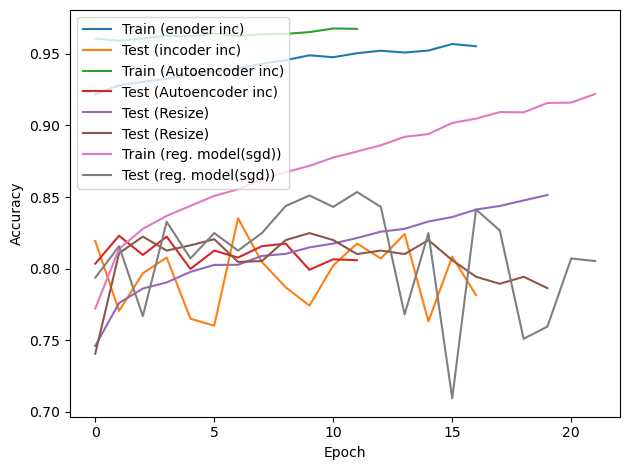

In [ ]:
plt.plot(reg_hist_sgd_ael.history['accuracy'], label='Train (enoder inc)' )
plt.plot(reg_hist_sgd_ael.history['val_accuracy'], label = 'Test (incoder inc)')
plt.plot(reg_hist_sgd_ael2.history['accuracy'], label = 'Train (Autoencoder inc)')
plt.plot(reg_hist_sgd_ael2.history['val_accuracy'], label = 'Test (Autoencoder inc)')
plt.plot(reg_hist_sgd_rez.history['accuracy'], label='Test (Resize)')
plt.plot(reg_hist_sgd_rez.history['val_accuracy'], label = 'Test (Resize)')
plt.plot(reg_hist_sgd.history['accuracy'], label = 'Train (reg. model(sgd))')
plt.plot(reg_hist_sgd.history['val_accuracy'], label = 'Test (reg. model(sgd))')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

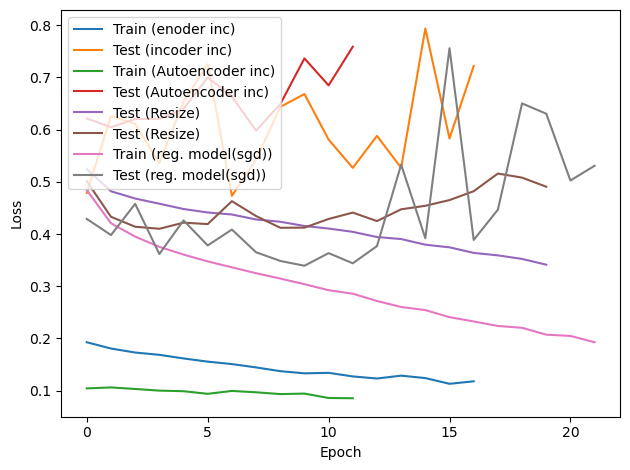

In [ ]:
plt.plot(reg_hist_sgd_ael.history['loss'], label='Train (enoder inc)' )
plt.plot(reg_hist_sgd_ael.history['val_loss'], label = 'Test (incoder inc)')
plt.plot(reg_hist_sgd_ael2.history['loss'], label = 'Train (Autoencoder inc)')
plt.plot(reg_hist_sgd_ael2.history['val_loss'], label = 'Test (Autoencoder inc)')
plt.plot(reg_hist_sgd_rez.history['loss'], label='Test (Resize)')
plt.plot(reg_hist_sgd_rez.history['val_loss'], label = 'Test (Resize)')
plt.plot(reg_hist_sgd.history['loss'], label = 'Train (reg. model(sgd))')
plt.plot(reg_hist_sgd.history['val_loss'], label = 'Test (reg. model(sgd))')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [146]:
rez_eval = model3_sgd_rez.evaluate(test_rez_dataset3)
sgd_eval = model3_sgd.evaluate(test_dataset2)
e_eval = model3_sgde.evaluate(test_dataset2)
ae_eval = model3_sgdae.evaluate(test_dataset2)

52/52 [==============================] - 1s 6ms/step - loss: 0.4687 - accuracy: 0.7924
